In [1]:
import geoopt
import torch
import numpy as np
import random
import logging
import json

In [30]:
weights = np.load("../models/hyperbolic/weights.npy")
song2ids = json.load(open("../models/hyperbolic/song2idx.json"))

In [2]:
from geomstats.learning.frechet_mean import FrechetMean
from geomstats.learning.pca import TangentPCA
from geomstats.geometry.hyperboloid import Hyperboloid

INFO: Using numpy backend


In [4]:
manifold = Hyperboloid(dim=weights.shape[1]-1)

In [6]:
mean = FrechetMean(metric=manifold.metric)
mean.fit(weights)

FrechetMean(metric=<geomstats.geometry.hyperboloid.HyperboloidMetric object at 0x7ff6ea5a9510>,
            point_type='vector')

In [7]:
tpca = TangentPCA(metric=manifold.metric, n_components=2)
tpca.fit(weights, base_point=mean.estimate_)
projected = tpca.transform(weights)

In [8]:
distances = manifold.metric.dist(mean.estimate_, weights)

Text(0, 0.5, 'Log frequency of item')

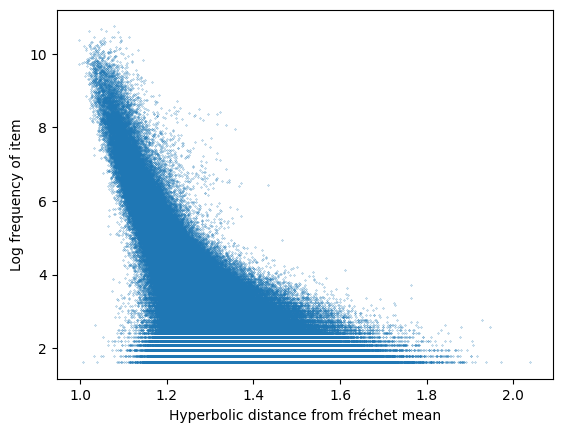

In [10]:
import matplotlib.pyplot as plt
freqs = json.load(open("../data/frequencies.json"))
colors = np.log([freqs[id_] for id_ in song2ids.keys()])
plt.scatter(distances, colors, s=0.05)
plt.xlabel("Hyperbolic distance from fréchet mean")
plt.ylabel("Log frequency of item")

In [34]:
import sys
sys.path.insert(0, "../src/")
from models.transformer.loader import PlaylistDataset
from models.transformer.transform import *
from models.transformer.model import TransformerModel

In [44]:
PAD_TOKEN = 0

MODEL_PATH = "../models/song2vec"
DATA_PATH ="../data"

NHEADS = 4
NLAYERS = 2
DROPOUT = .2
DHIDDEN = 256

SEQLEN = 75
PPF = 50000

BATCH_SIZE = 48

def load_transformer(nheads, nlayers, dhidden, model_path, embeddings_path):
    wv = Word2Vec.load(embeddings_path).wv
    dim = wv.vectors.shape[1]
    # TODO save padding vector
    embeddings = np.concatenate((np.random.normal(size=(1, dim)), wv.vectors), axis=0) * 0
    transformer = TransformerModel(
        embeddings=torch.tensor(embeddings),
        nhead=NHEADS,
        nlayers=NLAYERS,
        dropout=DROPOUT,
        d_hid=DHIDDEN
    )
    transformer.load_state_dict(torch.load(model_path, map_location="cpu"))
    return transformer, wv.key_to_index

tf, s2i = load_transformer(NHEADS, NLAYERS, DHIDDEN, "../models/transformer/transformer_model.pt", "../models/w2v/song2vec")

INFO: loading Word2Vec object from ../models/w2v/song2vec
INFO: loading wv recursively from ../models/w2v/song2vec.wv.* with mmap=None
INFO: loading vectors from ../models/w2v/song2vec.wv.vectors.npy with mmap=None
INFO: loading syn1neg from ../models/w2v/song2vec.syn1neg.npy with mmap=None
INFO: setting ignored attribute cum_table to None
INFO: Word2Vec lifecycle event {'fname': '../models/w2v/song2vec', 'datetime': '2023-05-11T17:23:30.938362', 'gensim': '4.3.1', 'python': '3.10.6 (main, Mar 10 2023, 10:55:28) [GCC 11.3.0]', 'platform': 'Linux-5.19.0-41-generic-x86_64-with-glibc2.35', 'event': 'loaded'}


In [45]:
from sklearn.neighbors import NearestNeighbors


class LorentzInnerProductNearestNeighbors:
    
    def __init__(self, manifold, k):
        self.k = k
        self.manifold = manifold
        
    def fit(self, x):
        if isinstance(x, np.ndarray):
            x = torch.tensor(x)
        self.x = x
        self.x0 = torch.zeros(x.shape[1]).to(x.device)
        
    @torch.no_grad()
    def _scores(self, x):
        if isinstance(x, np.ndarray):
            x = torch.tensor(x)
        if len(x.shape) > 1:
            return torch.stack([self.manifold.inner(self.x0, self.x, xi) for xi in x], dim=0)
        return self.manifold.inner(self.x0, self.x, x)
    
    def kneighbors(self, x, return_distance=True, include_self=False):
        scores = self._scores(x)
        order = np.argsort(-scores, axis=-1)
        offset, k = 0 if include_self else 1, self.k if include_self else self.k+1
        if return_distance:
            return -scores[order], order[:, offset:k]
        return order[:, offset:k].cpu().numpy()

In [80]:
from collections import Counter

class Recommender:
    
    def __init__(self, song2ids, knn, vecs):
        self.song2ids = song2ids
        self.ids2song = {v:k for k,v in song2ids.items()}
        self.known_songs = set(song2ids.keys())
        self._vecs = vecs
        self.knn = knn
        self.knn.fit(vecs)
        
    def recommend(self, songs, k=500):
        assert isinstance(songs, list), "Must provide list!"
        songs = list(filter(lambda song: song in self.known_songs, songs))
        ids = [self.song2ids[song] for song in songs]
        vecs = self._vecs[ids]
        nns = self.knn.kneighbors(vecs, return_distance=False)
        recommendations = [[self.ids2song[neighbor] for neighbor in song_neighbors] for song_neighbors in nns]
        c = Counter(reduce(list.__add__, recommendations))
        return [song for song,_ in c.most_common(k)]
    
    

class TransformerRecommender:
    
    def __init__(self, transformer, song2ids):
        self.transformer = transformer
        self.song2ids = song2ids
        self.ids2song = {v:k for k,v in song2ids.items()}
        self.known_songs = set(song2ids.keys())
        
    @torch.no_grad()
    def recommend(self, songs, k=500):
        assert isinstance(songs, list), "Must provide list!"
        songs = list(filter(lambda song: song in self.known_songs, songs))
        ids = [self.song2ids[song] + 1 for song in songs] # add 1 bc of padding
        ids.append(0) # the masked node
        x = torch.tensor(ids).view(-1,1)
        y = self.transformer(x)[-1].view(-1)
        order = np.argsort(-y)[:k].tolist()
        return [self.ids2song[n] for n in order]

In [81]:
import os

# utils to create this file list

def get_file_list(base):
    return [os.path.join(base, f) for f in os.listdir(base) if ".json" in f]

files = get_file_list("../data/processed/")
len(files)

20

In [84]:
dataset = PlaylistDataset(files, 50_000)

#knn = LorentzInnerProductNearestNeighbors(geoopt.manifolds.Lorentz(1, learnable=False), 50)
#knn = NearestNeighbors(n_neighbors=50, metric="cosine")
#r = Recommender(song2ids, knn, weights)
r = TransformerRecommender(tf.eval(), s2i)

In [85]:
from functools import reduce

for playlist in dataset:
    split = min(15, len(playlist) // 2)
    part1, part2 = playlist[:split], set(playlist[split:])
    recs = set(r.recommend(part1, k=500))
    hits = len(recs & part2)
    hr = hits / split
    print(hits)

35
4
0
0
0
1
1
30
7
4
0
14
0
0
1
2
4
4
2
3
5
0
1
1
0
1
3
0
0
0
3
2
2
6
2
0
0
1
0
0
0
2
0
26
0
11
1
2
7
7
16
4
0
0
1
14
7
0
0
10
0
1
0
1
0
0
5
1
1
7
0
0
2
3
2
0
1
1
3


KeyboardInterrupt: 

In [100]:
l = list(range(10))
split = 5
l[:split], l[split:]

([0, 1, 2, 3, 4], [5, 6, 7, 8, 9])

In [68]:
from gensim.models import Word2Vec

wv = Word2Vec.load("../models/w2v/song2vec").wv
weights = wv.vectors
song2ids = wv.key_to_index

INFO: loading Word2Vec object from ../models/w2v/song2vec
INFO: loading wv recursively from ../models/w2v/song2vec.wv.* with mmap=None
INFO: loading vectors from ../models/w2v/song2vec.wv.vectors.npy with mmap=None
INFO: loading syn1neg from ../models/w2v/song2vec.syn1neg.npy with mmap=None
INFO: setting ignored attribute cum_table to None
INFO: Word2Vec lifecycle event {'fname': '../models/w2v/song2vec', 'datetime': '2023-05-11T17:37:58.186685', 'gensim': '4.3.1', 'python': '3.10.6 (main, Mar 10 2023, 10:55:28) [GCC 11.3.0]', 'platform': 'Linux-5.19.0-41-generic-x86_64-with-glibc2.35', 'event': 'loaded'}


In [69]:
dataset = PlaylistDataset(files, 50_000)

#knn = LorentzInnerProductNearestNeighbors(geoopt.manifolds.Lorentz(1, learnable=False), 50)
knn = NearestNeighbors(n_neighbors=50, metric="cosine")
r = Recommender(song2ids, knn, weights)

In [86]:
from functools import reduce

for playlist in dataset:
    split = min(15, len(playlist) // 2)
    part1, part2 = playlist[:split], set(playlist[split:])
    recs = set(r.recommend(part1, k=500))
    hits = len(recs & part2)
    hr = hits / split
    print(hits)

500
35
500
4
500
0
500
0
500
0
500
1
500
1
500
30
500
7
500
4
500
0
500
14
500
0
500
0
500
1
500
2
500
4
500
4
500
2
500
3
500
5
500
0
500
1
500
1
500
0
500
1
500
3
500
0
500
0
500
0
500
3
500
2
500
2
500
6
500
2
500
0
500
0
500
1
500
0
500
0
500
0
500
2
500
0
500
26
500
0
500
11
500
1
500
2
500
7
500
7
500
16
500
4
500
0
500
0
500
1
500
14
500
7
500
0


KeyboardInterrupt: 